# Clasificando latídos cardíacos

https://www.kaggle.com/datasets/shayanfazeli/heartbeat/code

Frecuencia de muestreo: $360 \frac{muestras}{segundo}$

Descomentar y ejecutar la siguiente celda para descargar el set de datos

In [1]:
# import kagglehub

# # Download latest version
# path = kagglehub.dataset_download("shayanfazeli/heartbeat")

# print("Path to dataset files:", path)

In [2]:
import pandas as pd
import matplotlib.pyplot as plt
plt.style.use("ggplot")
import seaborn as sns
import numpy as np

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.preprocessing import OneHotEncoder

Cargamos los datos de entrenamiento y de testeo.

In [3]:
train = pd.read_csv('dataset\\mitbih_train.csv', header=None)
test = pd.read_csv('dataset\\mitbih_test.csv', header=None)

print(train.shape, test.shape)

(87554, 188) (21892, 188)


Podemos ver que tenemos 87554 datos de entrenamiento y 21892 datos de testeo.

Ahora bien, según el sitio que provee los datos, la última columna de los csv contienen las etiquetas correspondientes al tipo de latído cardíaco para una observación en particular.

Los valores de las etiquetas y el tipo de latidos, son:

- 0: "Normal",
- 1: "Artial Premature",
- 2: "Premature ventricular contraction",
- 3: "Fusion of ventricular and normal",
- 4: "Fusion of paced and normal": Los latidos de fusión ventricular pueden ocurrir cuando el ritmo natural del corazón y el impulso de un marcapasos coinciden para activar la misma parte de un ventrículo al mismo tiempo.

Veamos cuantos datos de cada uno tenemos.

In [4]:
train.iloc[:, 187].value_counts()

187
0.0    72471
4.0     6431
2.0     5788
1.0     2223
3.0      641
Name: count, dtype: int64

In [5]:
test.iloc[:, 187].value_counts()

187
0.0    18118
4.0     1608
2.0     1448
1.0      556
3.0      162
Name: count, dtype: int64

La mayoría de los datos corresponden a latidos normales, seguidos por los latidos de fusión ventricular.

In [6]:
data_train, labels_train = train.iloc[:, :187].values, train.iloc[:, 187].values
data_test, labels_test = test.iloc[:, :187].values, test.iloc[:, 187].values

Vamos a generar una función para obtener los datos correspondientes a un sólo tipo de latido

In [7]:
def getHeartbetType(samples, labels, type = 0):
    """
    samples: numpy array 2D con los samples
    labels: numpy array 1D con las etiquetas.
    type: tipo de latido. Es un número entero. 
    """
    filter = labels == type

    return samples[filter], labels[filter]

In [8]:
normal_beats, _ = getHeartbetType(data_train, labels_train, type=0)
fussion_beats, _ = getHeartbetType(data_train, labels_train, type=4)

Vamos a graficar algunos latídos cardíacos normales.

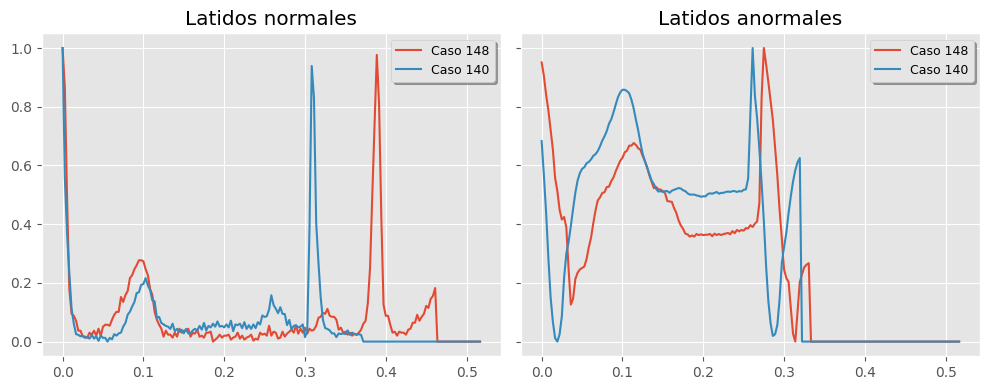

In [9]:
fs = 360
ejet = np.arange(0, data_train.shape[1])*1/fs
index = [148, 140]
# index = np.random.randint(0, data_train.shape[1], 2)

fig, ax = plt.subplots(1, 2, sharey=True, figsize=(10, 4))
ax[0].plot(ejet, data_train[index[0],:],label=f"Caso {index[0]}")
ax[0].plot(ejet, data_train[index[1], :], label=f"Caso {index[1]}")
ax[0].legend(shadow=True, frameon=True, facecolor="inherit", loc=1, fontsize=9)
ax[0].set_title("Latidos normales")

ax[1].plot(ejet, fussion_beats[index[0], :], label=f"Caso {index[0]}")
ax[1].plot(ejet, fussion_beats[index[1], :], label=f"Caso {index[1]}")
ax[1].legend(shadow=True, frameon=True, facecolor="inherit", loc=1, fontsize=9)
ax[1].set_title("Latidos anormales")

plt.tight_layout()
plt.show()

## Generando datos de entrenamiento y testeo

Vamos a tomar los datos correspondientes a latidos normales y de fusión ventricular, es decir, etiquetas $0$ y $4$.

Usaremos estas para entrenar una red y clasificar latidos normales vs enfermos.

In [10]:
##primero usamos getHeartbetType sobre los datos de entrenamiento y testeo

normal_train_data, normal_train_labels = getHeartbetType(data_train, labels_train, type=0)
normal_test_data, normal_test_labels = getHeartbetType(data_test, labels_test, type=0)

anormal_train_data, anormal_train_labels = getHeartbetType(data_train, labels_train, type=4)
anormal_test_data, anormal_test_labels = getHeartbetType(data_test, labels_test, type=4)

##reemplazo los valores 4 por 1 en las etiquetas
fussion_beats_train_labels = np.ones(anormal_train_labels.shape)
fussion_beats_test_labels = np.ones(anormal_test_labels.shape)

Ahora formo X_train, y_train, X_test e y_test concatenando los datos anteriores.

In [11]:
#Ahora formo X_train, y_train, X_test e y_test concatenando los datos anteriores.
X_train = np.concatenate((normal_train_data, anormal_train_data))
y_train = np.concatenate((normal_train_labels, fussion_beats_train_labels))
y_train = y_train.reshape(-1, 1)
X_test = np.concatenate((normal_test_data, anormal_test_data))
y_test = np.concatenate((normal_test_labels, fussion_beats_test_labels))
y_test = y_test.reshape(-1, 1)
y_test

array([[0.],
       [0.],
       [0.],
       ...,
       [1.],
       [1.],
       [1.]])

### Normalizando los datos

A continuación vamos a estandarizar los datos. Esto quiere decir, que haremos que nuestros datos tengan media 0 y desvío estándar 1.

Utilizaremos el módulo [StandardScaler](https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.StandardScaler.html).

In [12]:
##uso StandardScaler para standardizar los datos
scaler = StandardScaler()
scaler.fit(X_train)
X_train = scaler.transform(X_train)

In [13]:
np.round(X_train.mean(), 2), np.round(X_train.std(), 2)

(-0.0, 1.0)

**IMPORTANTE**: La variable *scaler* contiene la media y el desvío estándar necesarios para ajustar nuevos datos. Estos valores han sido sacados de los datos de entrenamiento.

Usaremos este scaler más adelante en nuestros datos de testeo.

## Generando nuestra red

A continuación vamos a usar nuestra clase *ANN* para armar una red que nos permita clasificar latidos cardíacos.

In [14]:
from Layers import Input, Dense
from ANN import NeuralNetwork
from loss_functions import mse, mse_prima
from activationsFunctions import *

La arquitectura de la red será:

- Input Layer con 187 nodos.
- Capa oculta 1 con 128 nodos.
- Capa oculta 2 con 64 nodos.
- Capa oculta 3 con 32 nodos.
- Capa de salida con 1 nodo. 

In [15]:
input_layer = Input(n_neuronas=(187,))

hidden_layer1 = Dense(ninputs=187, noutputs=128, activation=relu, activation_prima=relu_prima,
                      weights_init="uniform", bias_init="zeros", name="DenseLayer1",random_seed=0)

hidden_layer2 = Dense(ninputs=128, noutputs=64, activation=relu, activation_prima=relu_prima,
                      weights_init="uniform", bias_init="zeros", name="DenseLayer2",random_seed=0)

hidden_layer3 = Dense(ninputs=64, noutputs=32, activation=relu, activation_prima=relu_prima,
                      weights_init="uniform", bias_init="zeros", name="DenseLayer3",random_seed=0)

output_layer = Dense(ninputs=32, noutputs=1, activation=sigmoid, activation_prima=sigmoid_prima,
                     weights_init="uniform", bias_init="zeros", name="OutputLayer",random_seed=0)

layers = [input_layer,hidden_layer1,hidden_layer2,hidden_layer3,output_layer] ##lista con mis capas
nn1 = NeuralNetwork(layers) ##creamos la red

nn1.use(loss=mse, loss_prima=mse_prima) ##definimos la función de pérdida

### Entrenando la red

In [16]:
nn1.train(X_train, y_train, learning_rate=0.01, epochs=1, tolerancia=1e-3, imprimir_cada=10)

Época 0, MSE: [5.90187161e-08]


In [17]:
data_clasificada = nn1.classify(scaler.transform(X_test))

## Analizando la performance de la red

In [18]:
##metricas
accuracy = accuracy_score(y_test, data_clasificada)
precision = precision_score(y_test, data_clasificada)
recall = recall_score(y_test, data_clasificada)
f1 = f1_score(y_test, data_clasificada)

print(f"Accuracy: {accuracy:.2f}")
print(f"Precision: {precision:.2f}")
print(f"Recall: {recall:.2f}")
print(f"F1: {f1:.2f}")

Accuracy: 0.98
Precision: 0.96
Recall: 0.83
F1: 0.89


### Matriz de confusión

In [19]:
##matriz de confusión
tp = np.sum((y_test==1) & (data_clasificada==1))
tn = np.sum((y_test==0) & (data_clasificada==0))
fp = np.sum((y_test==0) & (data_clasificada==1))
fn = np.sum((y_test==1) & (data_clasificada==0))

mc = np.array([[tp,fn],[fp,tn]])
#normalizo la matriz de confusión. La normalización se hace dividiendo cada elemento por la suma de la columna
mc_norm = mc/mc.sum(axis=0)

print(mc)
print(mc_norm.round(3)) 

[[ 1342   266]
 [   54 18064]]
[[0.961 0.015]
 [0.039 0.985]]


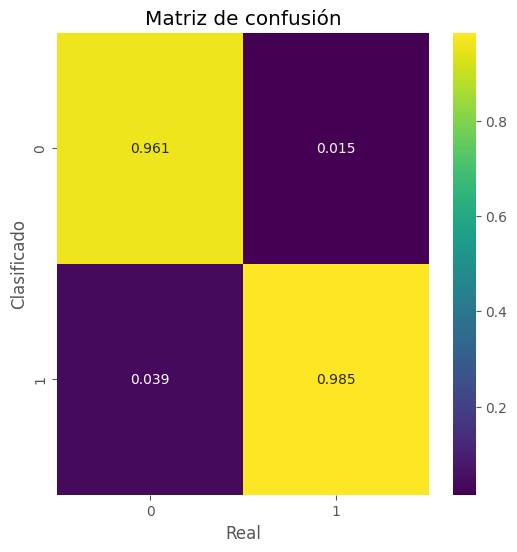

In [20]:
plt.figure(figsize=(6,6))
sns.heatmap(mc_norm.round(3), annot=True, cmap='viridis', fmt='g')
plt.xlabel('Real')
plt.ylabel('Clasificado')
plt.title('Matriz de confusión')
plt.show() 

### Testeando la red para clasificación multiclase

In [21]:
normal_X_train, normal_y_train = getHeartbetType(data_train, labels_train, type=0)
fussion_X_train, fussion_y_train = getHeartbetType(data_train, labels_train, type=4)
atrial_X_train, atrial_y_train = getHeartbetType(data_train, labels_train, type=2)

##testeo
normal_X_test, normal_y_test = getHeartbetType(data_test, labels_test, type=0)
fussion_X_test, fussion_y_test = getHeartbetType(data_test, labels_test, type=4)
atrial_X_test, atrial_y_test = getHeartbetType(data_test, labels_test, type=2)

##uno los datos de entrenamiento
X_train_multiclass = np.concatenate((normal_X_train, fussion_X_train, atrial_X_train))
y_train_multilabel = np.concatenate((normal_y_train, fussion_y_train, atrial_y_train))
y_train_multilabel = y_train_multilabel.reshape(-1, 1)
##uno los datos de testeo
X_test = np.concatenate((normal_X_test, fussion_X_test, atrial_X_test))
y_test = np.concatenate((normal_y_test, fussion_y_test, atrial_y_test))
y_test = y_test.reshape(-1, 1)

##utilizo onehotencoder para codificar las etiquetas
encoder = OneHotEncoder()
y_train_multilabel = encoder.fit_transform(y_train_multilabel)

##uso StandardScaler para standardizar los datos
scaler = StandardScaler()
scaler.fit(X_train_multiclass)

X_train_multiclass = scaler.transform(X_train_multiclass)

In [22]:
input_layer = Input(n_neuronas=(187,))

hidden_layer1 = Dense(ninputs=187, noutputs=128, activation=relu, activation_prima=relu_prima,
                      weights_init="uniform", bias_init="zeros", name="DenseLayer1",random_seed=0)

hidden_layer2 = Dense(ninputs=128, noutputs=64, activation=relu, activation_prima=relu_prima,
                      weights_init="uniform", bias_init="zeros", name="DenseLayer2",random_seed=0)

hidden_layer3 = Dense(ninputs=64, noutputs=32, activation=relu, activation_prima=relu_prima,
                      weights_init="uniform", bias_init="zeros", name="DenseLayer3",random_seed=0)

output_layer = Dense(ninputs=32, noutputs=3, activation=sigmoid, activation_prima=sigmoid_prima,
                     weights_init="uniform", bias_init="zeros", name="OutputLayer",random_seed=0)

layers = [input_layer,hidden_layer1,hidden_layer2,hidden_layer3,output_layer] ##lista con mis capas
nn2 = NeuralNetwork(layers) ##creamos la red

nn2.use(loss=mse, loss_prima=mse_prima) ##definimos la función de pérdida

In [23]:
##entrenamos la red
nn2.train(X_train_multiclass, y_train_multilabel, learning_rate=0.01, epochs=5, tolerancia=1e-3, imprimir_cada=10)

Época 0, MSE: [[1.66654144e-01 2.22222119e-01 1.08396127e-09]]


In [38]:
##clasificamos
data_clasificada = nn2.classify(scaler.transform(X_test))
nn2.predict(scaler.transform(X_test))

array([[9.99999990e-01, 5.89139687e-05, 1.52918361e-10],
       [9.99999999e-01, 3.95331097e-08, 7.93378949e-15],
       [9.99991112e-01, 1.09647350e-06, 8.13737626e-12],
       ...,
       [1.00000000e+00, 7.37106732e-11, 1.52502479e-10],
       [3.65130191e-03, 3.39963150e-04, 6.87968056e-08],
       [3.22570270e-06, 9.48340751e-30, 1.78305087e-37]])